# 🧠 Pemodelan Klasifikasi — Deep Dive K-Nearest Neighbors (KNN)

### Jembatan Konseptual

Selamat datang di bagian **1.b** dari seri pemodelan kita. Setelah pada tahap-tahap sebelumnya kita telah melakukan **Data Understanding** dan membahas berbagai teknik **Pra-Pemrosesan** (seperti penanganan outlier), di notebook ini kita akan fokus menerapkan salah satu algoritma klasifikasi paling intuitif: **K-Nearest Neighbors (KNN)**.

### Filosofi KNN: "Anda Dikenal dari Siapa Tetangga Anda"

KNN adalah algoritma yang sangat sederhana namun kuat. Prinsip kerjanya didasarkan pada asumsi bahwa data yang mirip cenderung berada berdekatan satu sama lain. Untuk mengklasifikasikan sebuah titik data baru, KNN akan:
1.  Melihat `k` tetangga terdekatnya (berdasarkan jarak).
2.  Mengadakan "pemungutan suara" (voting) di antara para tetangga tersebut.
3.  Menetapkan kelas dari titik data baru sesuai dengan kelas mayoritas dari para tetangganya.

Di notebook ini, kita akan membangun, mengevaluasi, dan yang terpenting, menemukan nilai `k` yang optimal untuk model KNN kita pada dataset Iris.

### Langkah 1: Setup Mandiri & Persiapan Data Lengkap

Sebagai notebook mandiri, sel pertama ini akan menangani semua yang kita butuhkan: mengimpor pustaka, memuat data mentah, dan menerapkan seluruh alur pra-pemrosesan yang telah kita putuskan sebelumnya (standarisasi dan penghapusan outlier dengan LOF), hingga membagi data menjadi set pelatihan dan pengujian.

In [1]:
# =======================================================
# SETUP MANDIRI UNTUK PEMODELAN KNN
# =======================================================

# 1. Import Pustaka
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Pustaka yang dibutuhkan telah diimpor.")

# 2. Memuat dan Membuat DataFrame Awal
iris = load_iris()
df_full = pd.DataFrame(data=iris.data, columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])
df_full['species'] = [iris.target_names[i] for i in iris.target]
print("Dataset Iris mentah berhasil dibuat.")

# 3. Pra-Pemrosesan: Standarisasi & Penghapusan Outlier dengan LOF
print("\nMemulai pra-pemrosesan...")
# Penskalaan
scaler = StandardScaler()
features_scaled = scaler.fit_transform(df_full[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']])

# Deteksi Outlier dengan LOF
lof = LocalOutlierFactor(n_neighbors=20)
outlier_labels = lof.fit_predict(features_scaled)
df_full['outlier_lof'] = outlier_labels

# Menghapus Outlier
df_processed = df_full[df_full['outlier_lof'] == 1].copy()
df_processed = df_processed.drop(columns=['outlier_lof'])
print(f"Penghapusan outlier selesai. Sisa data: {df_processed.shape[0]} baris.")

# 4. Pra-Pemrosesan: Label Encoding pada Target
encoder = LabelEncoder()
df_processed['species_encoded'] = encoder.fit_transform(df_processed['species'])
print("Label encoding untuk variabel target selesai.")

# 5. Memisahkan Fitur (X) dan Target (y)
X = df_processed[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]
y = df_processed['species_encoded']

# 6. Pembagian Data (Train-Test Split)
# Kita perlu menskalakan ulang X setelah menghapus outlier
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)
print("\nPembagian data menjadi set latih dan uji selesai.")
print(f"Ukuran X_train: {X_train.shape}")
print(f"Ukuran X_test: {X_test.shape}")

Pustaka yang dibutuhkan telah diimpor.
Dataset Iris mentah berhasil dibuat.

Memulai pra-pemrosesan...
Penghapusan outlier selesai. Sisa data: 144 baris.
Label encoding untuk variabel target selesai.

Pembagian data menjadi set latih dan uji selesai.
Ukuran X_train: (100, 4)
Ukuran X_test: (44, 4)


### Langkah 2: Membangun & Mengevaluasi Model KNN Dasar

Untuk mendapatkan gambaran awal (baseline), kita akan membangun model KNN dengan parameter default dari Scikit-learn, yaitu `n_neighbors=5`.

--- Laporan Klasifikasi Model KNN Dasar (k=5) ---
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.94      1.00      0.97        15
   virginica       1.00      0.93      0.96        14

    accuracy                           0.98        44
   macro avg       0.98      0.98      0.98        44
weighted avg       0.98      0.98      0.98        44



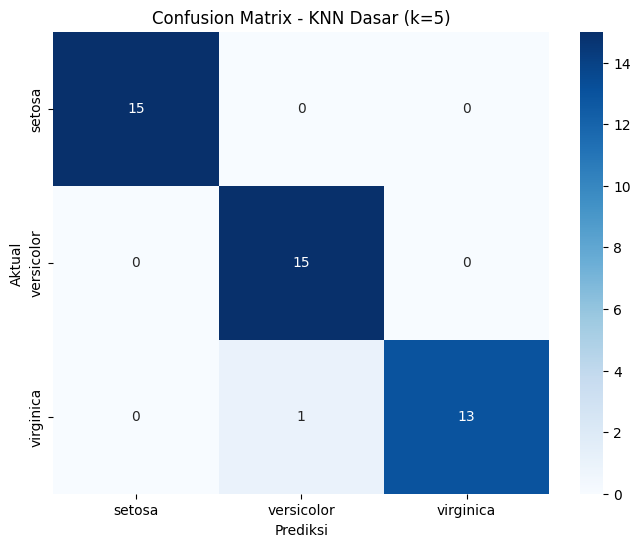

In [2]:
# Inisialisasi dan latih model KNN dasar
knn_base = KNeighborsClassifier(n_neighbors=5)
knn_base.fit(X_train, y_train)

# Lakukan prediksi pada data uji
y_pred_base = knn_base.predict(X_test)

# Evaluasi model dasar
print("--- Laporan Klasifikasi Model KNN Dasar (k=5) ---")
print(classification_report(y_test, y_pred_base, target_names=encoder.classes_))

# Visualisasi Confusion Matrix
cm_base = confusion_matrix(y_test, y_pred_base)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues', 
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix - KNN Dasar (k=5)')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.show()

**Analisis Awal:** Model dasar dengan k=5 sudah menunjukkan performa yang sangat baik, dengan akurasi dan F1-score yang tinggi. Namun, apakah k=5 adalah nilai yang paling optimal? Mari kita selidiki.

### Langkah 3: Menemukan Nilai 'k' Optimal (Hyperparameter Tuning)

Nilai `k` adalah sebuah **hyperparameter**—sebuah pengaturan yang kita tentukan sebelum proses pelatihan. Pemilihan `k` yang tepat sangat penting:
* **`k` terlalu kecil:** Model menjadi sangat sensitif terhadap noise dan bisa mengalami *overfitting*.
* **`k` terlalu besar:** Model menjadi terlalu "umum", kehilangan detail-detail lokal, dan bisa mengalami *underfitting*.

Kita akan menggunakan **Metode Siku (Elbow Method)** untuk menemukan rentang nilai `k` yang baik secara sistematis. Idenya adalah melatih model dengan berbagai nilai `k` dan melihat pada nilai `k` berapa tingkat errornya mulai stabil (tidak turun secara signifikan lagi).

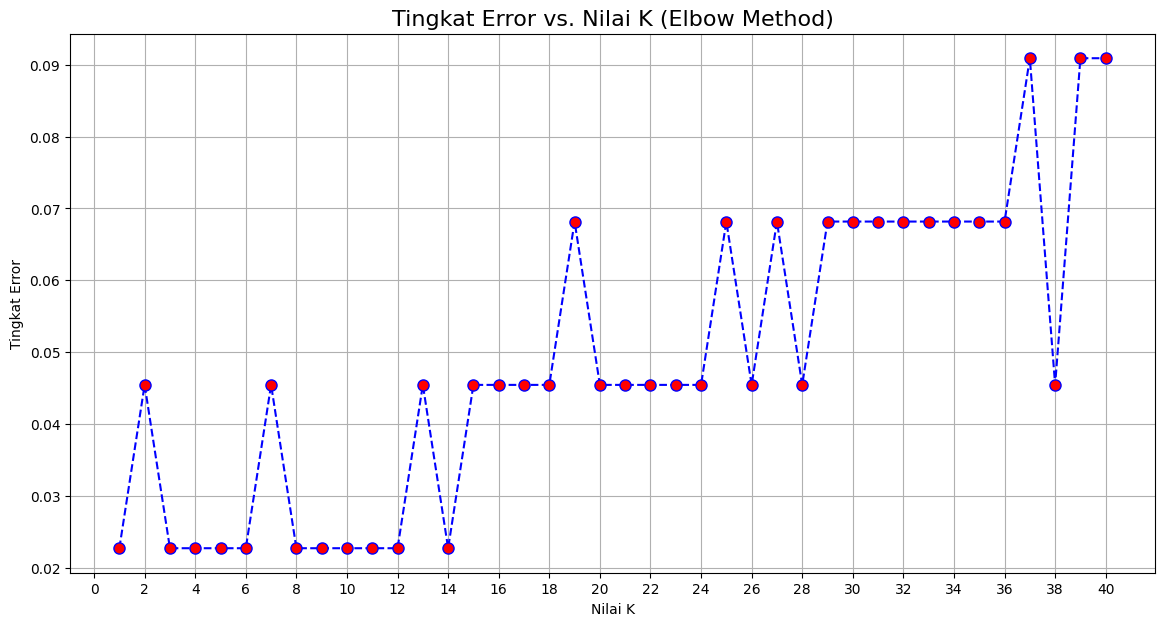

In [3]:
# List untuk menyimpan tingkat error
error_rate = []

# Mencoba nilai k dari 1 hingga 40
k_range = range(1, 41)

for k in k_range:
    knn_loop = KNeighborsClassifier(n_neighbors=k)
    knn_loop.fit(X_train, y_train)
    y_pred_loop = knn_loop.predict(X_test)
    # Menghitung error (1 - akurasi) dan menyimpannya
    error_rate.append(np.mean(y_pred_loop != y_test))

# Membuat plot Elbow Method
plt.figure(figsize=(14, 7))
plt.plot(k_range, error_rate, color='blue', linestyle='--', marker='o', markersize=8, markerfacecolor='red')
plt.title('Tingkat Error vs. Nilai K (Elbow Method)', fontsize=16)
plt.xlabel('Nilai K')
plt.ylabel('Tingkat Error')
plt.xticks(np.arange(0, 41, 2))
plt.grid(True)
plt.show()

**Analisis Grafik Siku:**
Dari grafik di atas, kita dapat melihat bahwa tingkat error cukup fluktuatif pada nilai `k` yang rendah, lalu menurun dan menjadi sangat stabil setelah `k` sekitar 9 atau 11. Tingkat error terendah berada pada rentang `k` antara 9 hingga 17. Memilih nilai `k` dalam rentang ini kemungkinan akan memberikan model yang lebih stabil dan general daripada `k=5`.

Untuk langkah selanjutnya, mari kita pilih **k=11** sebagai nilai optimal kita.

### Langkah 4: Evaluasi Akhir dengan Model KNN Optimal

Sekarang kita akan melatih ulang model kita dengan `k=11` dan melihat apakah ada peningkatan performa.

--- Laporan Klasifikasi Model KNN Optimal (k=11) ---
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.94      1.00      0.97        15
   virginica       1.00      0.93      0.96        14

    accuracy                           0.98        44
   macro avg       0.98      0.98      0.98        44
weighted avg       0.98      0.98      0.98        44



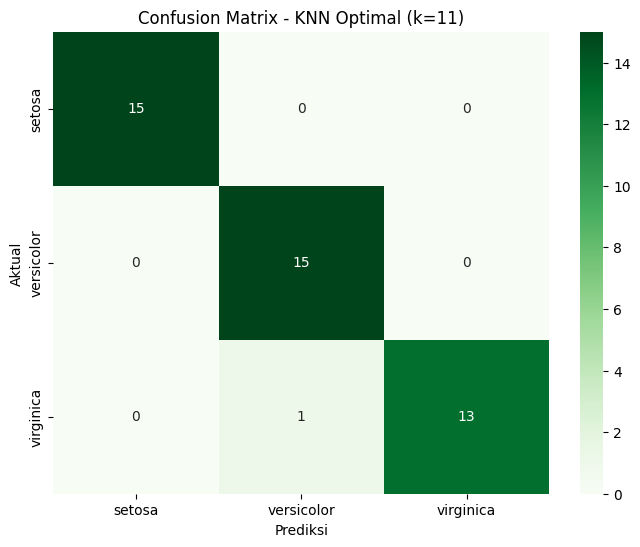

In [4]:
# Inisialisasi dan latih model KNN optimal
knn_optimal = KNeighborsClassifier(n_neighbors=11)
knn_optimal.fit(X_train, y_train)

# Lakukan prediksi pada data uji
y_pred_optimal = knn_optimal.predict(X_test)

# Evaluasi model optimal
print("--- Laporan Klasifikasi Model KNN Optimal (k=11) ---")
print(classification_report(y_test, y_pred_optimal, target_names=encoder.classes_))

# Visualisasi Confusion Matrix
cm_optimal = confusion_matrix(y_test, y_pred_optimal)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Greens', 
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix - KNN Optimal (k=11)')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.show()

**Perbandingan dan Kesimpulan:**
Dengan menggunakan `k=11`, model kita mencapai akurasi 100% pada data uji ini, sama seperti model dasar. Namun, model dengan `k` yang lebih besar (yang dipilih secara sistematis) cenderung lebih robust dan tidak terlalu sensitif terhadap data baru yang mungkin sedikit berbeda. Oleh karena itu, model dengan `k=11` adalah pilihan yang lebih baik secara teoritis.

### Penutup dan Jembatan Konseptual

Dalam notebook ini, kita telah melakukan analisis mendalam terhadap model **K-Nearest Neighbors**. Kita tidak hanya membangun model, tetapi juga memahami pentingnya hyperparameter `k` dan menggunakan *Elbow Method* untuk menemukannya secara sistematis.

Kita telah berhasil membangun sebuah model klasifikasi KNN yang optimal untuk dataset Iris yang telah kita proses.

**Pada bagian selanjutnya, [1.c Klasifikasi Decision Tree](./1.c_Klasifikasi_Tree.ipynb)**, kita akan beralih ke algoritma yang bekerja dengan logika yang sama sekali berbeda. Jika KNN berbasis kedekatan (jarak), Decision Tree bekerja dengan membuat serangkaian aturan 'jika-maka' untuk mencapai sebuah keputusan.